<a href="https://colab.research.google.com/github/davidislip/SVM-and-MVO/blob/main/Joint_Optimization_2_Factor_Single_Month.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Integration of SVM and MVO 
The idea is to integrate support vector machines and mean variance optimization 

$$
\begin{align} 
\min_{x, z, w, b} \quad & x^{\intercal}\Sigma x + \frac{1}{2}||{w}||^2 &\\ 
\textrm{s.t.} \quad & \mu^\intercal x  \geq \bar{R} \\
\quad & z_i \leq M x_i &\forall i = 1,2,...,N  \\
\quad & x_i \leq z_i \quad &\forall i = 1,2,...,N \\
              \quad & y_i^{\intercal} w + b \leq M z_i - \epsilon \quad & \forall i = 1,2,...,N \\
              \quad & -M(1-z_i) + \epsilon \leq  y_i^{\intercal} w + b \quad &\forall i = 1,2,...,N \\
              \quad & x \in \mathcal{C} \quad z \in \{0,1\}^N & \\
\end{align} 
$$

In [52]:
!sudo python -m pip install gurobipy==9.1.2
import gurobipy as gp
from gurobipy import GRB
from google.colab import drive 
drive.mount('/content/gdrive')
from math import sqrt
import sys
pth = 'gdrive/My Drive/Colab Notebooks/'
sys.path.append(pth + 'SVM MVO/PYFILES/')
from packages import *
%matplotlib inline

## Import Forecasts
forecasts = pd.read_pickle(pth +'SVM MVO/DATA/Forecasts.pkl')
## Import Returns
rets = pd.read_pickle(pth + 'SVM MVO/DATA/RETS.pkl')
## Import feature vectors
wrds_svm = pd.read_pickle(pth + 'SVM MVO/DATA/WRDS_ASOF.pkl')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [53]:
e = gp.Env(empty=True)
gurobi_licence = pd.read_csv(pth +'SVM MVO/DATA/gurobi.csv')
e.setParam('WLSACCESSID', gurobi_licence.WLSACCESSID[0])
e.setParam('LICENSEID', gurobi_licence.LICENSEID[0])
e.setParam('WLSSECRET', gurobi_licence.WLSSECRET[0])
e.start()

Changed value of parameter WLSACCESSID
Changed value of parameter LICENSEID
Changed value of parameter WLSSECRET
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Using license file /usr/local/lib/python3.7/dist-packages/gurobipy/.libs/gurobi.lic
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID


<gurobipy.Env, No parameter changes>

In [54]:
mth = rets.index[0]
mth

Timestamp('2000-07-01 00:00:00')

In [63]:
#preprocessing 
cov_, mean_ = forecasts[mth]
N = 100
cov = cov_[:N,:N]
mean = mean_[:N,:]
tics = list(rets.columns[:N])
print("valid tickers:", tics)
#get the wharton research data for the valid tickers for the month
wrds_tics = wrds_svm[wrds_svm.index.get_level_values('tic').isin(tics)].xs(mth, level="MonthStart")
#restrict the wharton research data to the columns of interest
Y = wrds_tics.loc[:,"ROC1":"GRW8"] # Y matrix in formulation 
Y_ =  (Y - Y.mean(axis=0))/(Y.std(axis=0))
Y_ = Y_.iloc[:,:]
#Y_ = Y_[['ROC1', 'INV1', 'PRO1'	, 'GRW1', 'LEV1', 'LIQ1']]
Y_ = Y_[['GRW3', 'GRW1']]
#Y_['momentum'] = mean
ret_constr = -1
soft_margin = 1000

valid tickers: ['AAPL', 'ABC', 'ABMD', 'ABT', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AJG', 'AKAM', 'ALB', 'ALK', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMT', 'AMZN', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'ATO', 'AVY', 'AZO', 'BA', 'BAX', 'BBY', 'BDX', 'BKNG', 'BLL', 'BMY', 'BSX', 'BWA', 'CAG', 'CAH', 'CAT', 'CCI', 'CCL', 'CDNS', 'CERN', 'CHD', 'CHRW', 'CI', 'CL', 'CLX', 'CMCSA', 'CMI', 'CMS', 'CNP', 'COO', 'COP', 'COST', 'CPB', 'CPRT', 'CSCO', 'CSX', 'CTAS', 'CTSH', 'CTXS', 'CVS', 'CVX', 'D', 'DD', 'DGX', 'DHR', 'DIS', 'DISH', 'DLTR', 'DOV', 'DRI', 'DTE', 'DUK', 'DVA', 'DVN', 'DXC', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'EMN', 'EMR', 'EOG', 'ES', 'ETN', 'ETR', 'EVRG', 'EXC', 'EXPD', 'F', 'FAST']


In [64]:
print(wrds_svm.columns[(wrds_svm == np.inf).any(axis = 0).values])

Index([], dtype='object')


In [65]:
mean

array([[ 0.07271981],
       [ 0.27477976],
       [-0.15518335],
       [ 0.11789107],
       [ 0.13575763],
       [-0.08407297],
       [-0.08297169],
       [ 0.00718053],
       [-0.03894175],
       [-0.04304447],
       [-0.13565771],
       [ 0.06290918],
       [ 0.14471001],
       [ 0.40758457],
       [-0.08149147],
       [-0.07082925],
       [ 0.02214004],
       [-0.07392576],
       [-0.1367862 ],
       [ 0.10785153],
       [ 0.00827223],
       [-0.20929482],
       [ 0.01896374],
       [-0.0719679 ],
       [ 0.02061205],
       [ 0.05864437],
       [-0.06982479],
       [ 0.28216841],
       [-0.04938862],
       [ 0.04096284],
       [-0.18233664],
       [ 0.08937364],
       [ 0.07285177],
       [-0.03546648],
       [ 0.04857269],
       [-0.14566807],
       [ 0.03019753],
       [ 0.09419487],
       [-0.06542316],
       [-0.09406549],
       [-0.08608611],
       [ 0.18804296],
       [-0.09974793],
       [ 0.11541801],
       [-0.14939698],
       [ 0

In [66]:
class SVMMVO:

  bigM = 100
  epsilon = 0.01
  def __init__(self, tics, mean_ret, cov, ret_constr, soft_margin, exogenous, \
               svm_choice = (False, False), print_var_frntr = False):
    self.tics = tics #list of tickers
    self.mean_ret = mean_ret
    self.cov = cov
    self.ret_constr = ret_constr

    self.soft_margin = soft_margin #hyper parameter
    self.exogenous = exogenous # matrix of features for the tickers
    self.svm_constr, self.slacks = svm_choice #Model configuration
    N, m = self.exogenous.shape

    self.model = gp.Model(env = e)
    self.x = self.model.addMVar(N)
    self.w = self.model.addMVar(m)
    self.b = self.model.addMVar(1)
    self.z = self.model.addMVar(N, vtype=GRB.BINARY)
    self.xi = self.model.addMVar(N, lb = np.zeros(N))
    self.print_var_frntr = print_var_frntr

    self.ret_target = self.model.addConstr(self.mean_ret[:,0] @ self.x \
                                           >= self.ret_constr, 'target')
    self.port_exptd_ret = self.mean_ret[:,0] @ self.x
    self.portfolio_risk = self.x @ self.cov @ self.x
    
  @property
  def describe(self):
    if self.svm_constr:
      if self.slacks:
        desc = "SVM MVO with Slacks with return = "+str(self.ret_constr)
        shrt = "SVMMVO_Slck_ret"+str(self.ret_constr)
      else:
        desc = "SVM MVO with no Slacks with return = "+str(self.ret_constr)
        shrt = "SVMMVO_ret"+str(self.ret_constr)
    else:
      desc = "Traditional MVO with return = "+str(self.ret_constr)
      shrt = "MVO_ret"+str(self.ret_constr)
    return (desc, shrt)
  
  def print_var_info(self, names = {}):
    #dictionary of variables and thier names
    for key in names.keys():
      print(key, names[key])
    print("x", self.x.X)
    print("w", self.w.X)
    print("z", self.z.X)
    print("xi", self.xi.X)
    print("")

  def setModel(self):

    #parameter definitions
    N, m = self.exogenous.shape
    bigM = SVMMVO.bigM
    epsilon = SVMMVO.epsilon
    #objective function components
    svm_margin = (1/2)*(self.w @ self.w)
    soft_penalty = (self.soft_margin/epsilon)*self.xi.sum()
    self.model.addConstr(self.x.sum() == 1, 'budget')

    if not self.svm_constr and self.slacks:
      #if we do not want to use svm then dont use svm with slack
      print("Cannot SVM with slack without SVM ... self.slacks set to False")
      self.slacks = svm_constr

    if self.svm_constr:
      self.model.addConstr(self.x <= self.z, "z force x" )  #if x is close to zero then z must be zero 
      self.model.addConstr(self.z <= 100*bigM*self.x, "z force x" )  # if z is zero then x must be zero 
      self.model.addConstr(self.b <= 0.5*epsilon, "b" ) # if z is zero then x must be zero 
      self.model.addConstr(self.b >= -0.5*epsilon, "b" ) # if z is zero then x must be zero 
 
      if self.slacks: #SVM MVO with slack variables
        self.model.setObjective(self.portfolio_risk + svm_margin + soft_penalty, GRB.MINIMIZE) 
        #adding the SVM type constraints
        for i in range(N):
          y_i = self.exogenous.iloc[i].values
          self.model.addConstr(self.w @ y_i + self.b <= (-1)*epsilon + self.xi[i] + (bigM)*self.z[i], "svm1" ) 
          self.model.addConstr(-1*  (bigM) *(1 - self.z[i])  + epsilon - self.xi[i] <= y_i @ self.w + self.b , "svm2" )

      else: #SVM MVO without slack variables - may not be feasible
        self.model.remove([self.xi])
        self.model.setObjective(self.portfolio_risk + svm_margin, GRB.MINIMIZE) 
        #adding the SVM type constraints
        for i in range(N): 
          y_i = self.exogenous.iloc[i].values
          self.model.addConstr(self.w @ y_i + self.b <= (-1)*epsilon +  (bigM)*self.z[i], "svm1" ) 
          self.model.addConstr(-1*  (bigM) *(1 - self.z[i])  + epsilon <= y_i @ self.w + self.b  , "svm2" )

    else:#not svm mvo
      self.model.setObjective(self.portfolio_risk, GRB.MINIMIZE)
      self.model.remove([self.w, self.b, self.z, self.xi])

  def optimize(self):

    self.model.optimize()
    self.model.write('portfolio_selection_optimization.lp')

  def evaluate(self, realized_ret):

    ret = np.dot(self.x.X, realized_ret)
    return ret #use this to calculate out of sample rets and var

  def get_estimates(self):

    vol_metric = np.sqrt(self.portfolio_risk.getValue())[0]
    expt_ret_metric = self.port_exptd_ret.getValue()[0]
    return [vol_metric, expt_ret_metric] #use this for efficient frontiers

  def get_results(self, export_dir = '', fig_size = ()):

    lng, shrt = self.describe
    vol_metric = np.sqrt(self.portfolio_risk.getValue())[0]
    expt_ret_metric = self.port_exptd_ret.getValue()[0]
    results = pd.DataFrame(data=np.append(self.x.X, [vol_metric, expt_ret_metric]),
    index= list(self.tics) + ['Volatility', 'Expected Return'], columns=[lng])

    if (export_dir != ''):
      results.to_csv(export_dir+'results.csv')

    if fig_size != () and type(fig_size) in [list, tuple]:
      results[:-2].plot.bar(figsize = fig_size)

    return  results.transpose()

  def get_frontier(self, export_dir = '', fig_size = (10,8)):

    N, m = self.exogenous.shape
    F = 25
    mean_ret = self.mean_ret[:,0]
    #F is the number of portfolios to use for frontier
    frontier = np.empty((2,F))
    #ws will contain the w's and b values for each portfolio 
    ws = np.empty((F, m+1))
    #xis will contain the w's and b values for each portfolio 
    xis = np.empty((F, N))
    #targets for returns
    ret_targ = np.linspace(mean_ret.min(), mean_ret.max(), F)

    expt_ret_metric = self.port_exptd_ret.getValue()[0]

    self.model.remove(self.ret_target)
    self.model.update()

    self.ret_target = self.model.addConstr(self.port_exptd_ret == expt_ret_metric, 'target ==')
    self.model.update()

    for i in range(F):
      self.ret_target[0].rhs = ret_targ[i]
      self.model.optimize()

      if  self.model.status == 4:
        break

      vol_metric = np.sqrt(self.portfolio_risk.getValue())[0]
      frontier[:,i] = np.array([vol_metric,ret_targ[i]])

      if self.svm_constr and self.slacks:
        ws[i,:] = np.concatenate([self.w.x, self.b.x])
        xis[i,:] = self.xi.x
        if self.print_var_frntr:
          self.print_var_info({"return": ret_targ[i]})

    if  self.model.status == 4:
      print("Resolving Model to initial state (return target) then exiting")
      self.model.remove(self.ret_target)
      self.model.update()
      self.ret_target = self.model.addConstr(self.port_exptd_ret >= self.ret_constr, 'target')
      self.model.optimize()
      return (None, None, None)

    #restore model to original state
    self.model.remove(self.ret_target)
    self.model.update()
    self.ret_target = self.model.addConstr(self.port_exptd_ret >= self.ret_constr, 'target')
    self.model.optimize()

    fig, ax = plt.subplots(figsize=fig_size)
    # Plot efficient frontier
    ax.plot(frontier[0], frontier[1], '-*', label='Efficient Frontier', color='DarkGreen')

    # Format and display the final plot
    ax.axis([frontier[0].min()*0.7, frontier[0].max()*1.3, mean_ret.min()*1.2, mean_ret.max()*1.2])
    ax.set_xlabel('Volatility (standard deviation)')
    ax.set_ylabel('Expected Return')
    # ax.legend()
    ax.grid()
    plt.show()
    if (export_dir != ''):
      plt.savefig(export_dir+"EfficientFrontier.png")
    return (frontier, ws, xis)


### Simple Min Variance Portfolio 

In [67]:
MVO = SVMMVO(tics, mean, cov, ret_constr, soft_margin, Y_,\
             svm_choice = (False, False), print_var_frntr= False) #define an instance of the class
MVO.setModel() #set up the model
MVO.optimize() #find optimal solution

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Optimize a model with 2 rows, 100 columns and 200 nonzeros
Model fingerprint: 0x17da780a
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [5e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-06, 7e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.03s
Presolved: 2 rows, 100 columns, 200 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 99
 AA' NZ     : 5.050e+03
 Factor NZ  : 5.151e+03
 Factor Ops : 3.486e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.59313424e+05 -1.5

,Traditional MVO with return = -1
AAPL,2.477363e-07
ABC,2.852401e-09
ABMD,4.697065e-03
ABT,3.538416e-03
ADBE,4.985158e-09
...,...
EXPD,7.635066e-09
F,3.597665e-02
FAST,2.901475e-09
Volatility,2.024881e-02


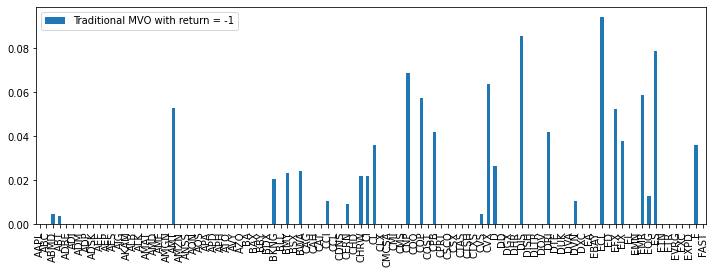

In [68]:
MVO.get_results(fig_size=(12,4)).transpose()

Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca

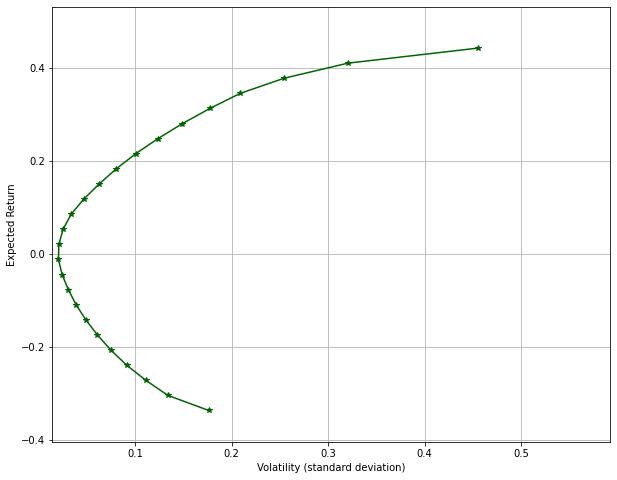

In [69]:
MVO.model.setParam('OutputFlag', 0)
MVO_frontier, ws, xis = MVO.get_frontier(); #ws and xi are not important here

### Mean Variance and SVM Joint Formulation

In [70]:
SVM_MVO = SVMMVO(tics, mean, cov, ret_constr, soft_margin, Y_, \
                 svm_choice = (True, False), print_var_frntr = False )
SVM_MVO.setModel()
SVM_MVO.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Optimize a model with 404 rows, 203 columns and 1402 nonzeros
Model fingerprint: 0x4163e59a
Model has 5052 quadratic objective terms
Variable types: 103 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [5e-04, 1e+04]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-06, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 1e+02]
Found heuristic solution: objective 0.0816567
Presolve removed 134 rows and 66 columns
Presolve time: 0.01s
Presolved: 270 rows, 137 columns, 885 nonzeros
Presolved model has 3083 quadratic objective terms
Variable types: 81 continuous, 56 integer (56 binary)

Root relaxation: objective 1.971115e-03, 168 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds    

In [71]:
SVM_MVO.z.x

array([-0.,  0.,  1., -0., -0.,  0., -0.,  0.,  1., -0.,  0.,  1.,  0.,
        1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1., -0., -0., -0.,  0.,
        1., -0.,  1.,  1.,  1., -0.,  1.,  0., -0., -0.,  1., -0., -0.,
       -0.,  1., -0., -0.,  1., -0.,  1.,  1.,  0.,  0., -0., -0.,  0.,
        1., -0., -0.,  0., -0.,  0., -0., -0., -0.,  0., -0., -0.,  0.,
       -0., -0., -0.,  1., -0., -0.,  0., -0.,  1.,  1., -0.,  1., -0.,
        0.,  1.,  0.,  0.,  1., -0., -0., -0.,  0.,  1., -0.,  0., -0.,
       -0., -0.,  1., -0., -0., -0.,  0.,  1., -0.])

In [72]:
SVM_MVO.get_frontier()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Optimize a model with 404 rows, 203 columns and 1402 nonzeros
Model fingerprint: 0x729d8f89
Model has 5052 quadratic objective terms
Variable types: 103 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [5e-04, 1e+04]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-06, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 1e+02]

MIP start from previous solve did not produce a new incumbent solution

Presolve removed 133 rows and 66 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.04 seconds
Thread count was 1 (of 2 available processors)

Solution count 0

Model is infeasible or unbounded
Best objective -, best bound -, gap -
Resolving Model to initial state (return target) then exiting
G

(None, None, None)

### There must be a model that is guaranteed to be feasible. Slack variables for the big M constraints will be introduced and penalized

$$
\begin{align} 
\min_{x, z, w, b} \quad & x^{\intercal}\Sigma x + \frac{1}{2}||{w}||^2 + \sum_{i=1}^N g(\xi_i)&\\ 
\textrm{s.t.} \quad & \mu^\intercal x  \geq \bar{R} \\
\quad & z_i \leq M x_i &\forall i = 1,2,...,N  \\
\quad & x_i \leq z_i \quad &\forall i = 1,2,...,N \\
              \quad & y_i^{\intercal} w + b \leq M z_i - \epsilon + \xi_i \quad & \forall i = 1,2,...,N \\
              \quad & -M(1-z_i) + \epsilon - \xi_i \leq  y_i^{\intercal} w + b \quad &\forall i = 1,2,...,N \\
              \quad & x \in \mathcal{C} \quad z \in \{0,1\}^N  \quad \xi \geq 0& \\
\end{align} 
$$

This model is always feasible. A common setting for g is $C \xi/N$ where $C$ is a hyperparameter. 

In [73]:
SVM_MVO_Slck = SVMMVO(tics, mean, cov, ret_constr, soft_margin, Y_, \
                      svm_choice = (True, True), print_var_frntr = True )
SVM_MVO_Slck.setModel()
SVM_MVO_Slck.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Optimize a model with 404 rows, 303 columns and 1602 nonzeros
Model fingerprint: 0xf418ed5b
Model has 5052 quadratic objective terms
Variable types: 203 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [5e-04, 1e+04]
  Objective range  [1e+05, 1e+05]
  QObjective range [8e-06, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 1e+02]
Found heuristic solution: objective 2.000000e+16
Presolve removed 3 rows and 0 columns
Presolve time: 0.00s
Presolved: 401 rows, 303 columns, 1478 nonzeros
Presolved model has 5052 quadratic objective terms
Variable types: 203 continuous, 100 integer (100 binary)

Root relaxation: objective 7.248617e-04, 283 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds

In [74]:
SVM_MVO_Slck.xi.x

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

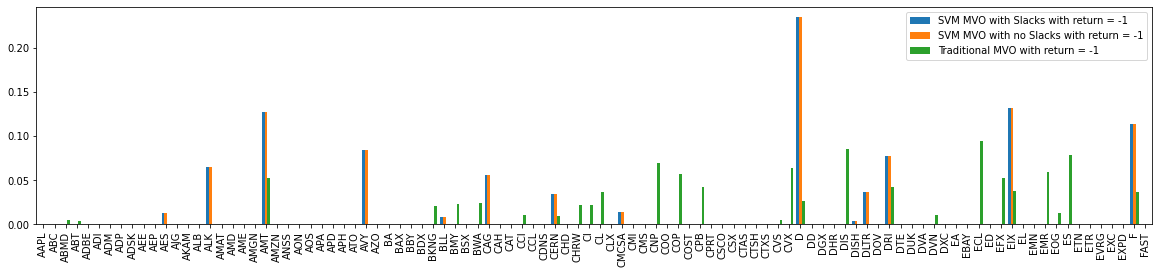

In [75]:
#portfolio comparison
out = pd.concat([SVM_MVO_Slck.get_results(), SVM_MVO.get_results(), MVO.get_results()], axis = 0)
out.transpose()[:-2].plot.bar(figsize = (20,4), width = 0.75);

In [76]:
SVM_MVO_Slck.xi.x

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
return -0.3372231374339163
x [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
w [0. 0.]
z [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
xi [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01

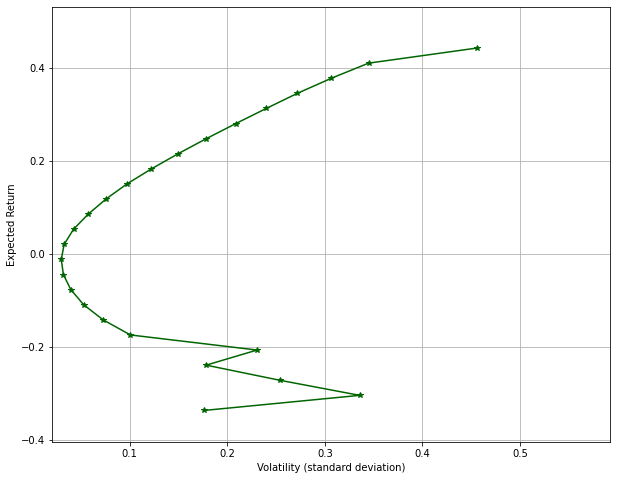

In [77]:
SVM_MVO_Slck.model.setParam('OutputFlag', 0)
SVMV_Slck_EF, ws, xis = SVM_MVO_Slck.get_frontier()

For the portfolios up to the return point of 0.3, the solver finds linearly separable portfolios. After that point the solver defaults to including all the assets in the universe at the expense of increasing the cost of violating the linearly separable condition. 

The bias term acts as a radius that determines how far separating hyperplanes can be from the origin. If the bias was free to be any value then, it would be set to ensure z = 1 for all assets, which would imply w = 0, no constraint violations xi = 0 (since all assets are covered), and would therefore reduce the problem to the mean variance problem. 

The bias could be set to cover a percentile of assets feature vectors Y ? 

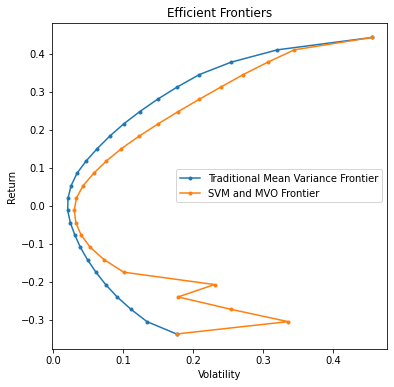

In [78]:
#Plot efficient frontiers for the SVM MVO an Vanilla MVO
plt.figure(figsize = (6,6))
plt.plot(MVO_frontier[0], MVO_frontier[1], ".-", label = "Traditional Mean Variance Frontier");
plt.plot(SVMV_Slck_EF[0], SVMV_Slck_EF[1], ".-", label = "SVM and MVO Frontier");
plt.legend();
plt.ylabel('Return')
plt.xlabel('Volatility')
plt.legend()
plt.title("Efficient Frontiers");

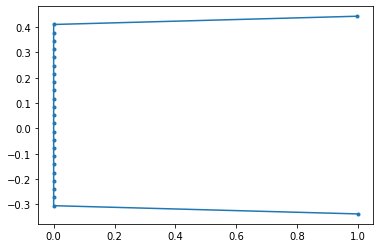

In [79]:
plt.plot(xis.sum(axis= 1), SVMV_Slck_EF[1], ".-", label = "Slacks for each target");

In [80]:
from sympy.solvers import solve
from sympy import Symbol

xu, yu = tuple(np.ceil(Y_.max()))
xl, yl = tuple(np.floor(Y_.min()))
epsi = 10**(-1)

def getline(ws):
  x = Symbol('x')
  y = Symbol('y')
  epsi = 10**(-9)

  if abs(ws[0]) >= epsi and abs(ws[1]) >=epsi:
    try:
      xxu = float(solve(ws[0]*x  + ws[1]*yu + ws[2]  , x)[0].evalf())
      xxl = float(solve(ws[0]*x  + ws[1]*yl + ws[2]  , x)[0].evalf())
      yyl = float(solve(ws[0]*xl  + ws[1]*y + ws[2]  , y)[0].evalf())
      yyu = float(solve(ws[0]*xu  + ws[1]*y + ws[2]  , y)[0].evalf())
    except:
      xxu = (-1)*(ws[1]*yu + ws[2])/ws[0]
      xxl = (-1)*(ws[1]*yl + ws[2])/ws[0]
      yyl = (-1)*(ws[0]*xl + ws[2])/ws[1]
      yyu = (-1)*(ws[0]*xu + ws[2])/ws[1]

    candidates = [(xxu, yu), (xxl, yl), (xl, yyl), (xu, yyu) ]
    tuples = []
    for tup in candidates:
      if tup[0] <= xu and tup[0] >= xl and tup[1] <= yu and tup[1] >= yl:
        tuples.append(tup)

  elif abs(ws[0]) >= epsi and abs(ws[1]) < epsi: #y coeff is small
    try:
      xx = float(solve(ws[0]*x + ws[2]  , x)[0].evalf())
    except:
      xx = (-1)*ws[2]/ws[0]
    

    if xx <= xu and xx >= xl:
      tuples = [(xx, yl), (xx, yu)]
    elif xx > xu:
      tuples = [(xu, yl), (xu, yu)]
    elif xx < xl:
      tuples = [(xl, yl), (xl, yu)]

  elif abs(ws[0]) < epsi and abs(ws[1]) >= epsi: #x coeff is small
    try:
      yy = float(solve(ws[1]*y + ws[2]  , y)[0].evalf())
    except:
      yy =  (-1)*ws[2]/ws[1]
    
    if yy <= yu and yy >= yl:
      tuples = [(xu, yy), (xl, yy)]
    elif yy > yu:
      tuples = [(xu, yu), (xl, yu)]
    elif yy < yl:
      tuples = [(xl, yl), (xl, yl)]

  else: 
    print("No Valid Separating Hyperplanes")
    return None 
  return tuples

In [81]:
supports  = pd.DataFrame(ws)
supports['ret'] = SVMV_Slck_EF[1,:]
bigM = 10**(6)
supports_uniq = supports.groupby([np.ceil(supports[0] * bigM) /bigM,  \
                  np.ceil(supports[1] * bigM) / bigM, \
                  np.ceil(supports[2] * bigM) / bigM]).first()
supports_uniq['last_ret'] = supports.groupby([np.ceil(supports[0] * bigM) /bigM,  \
                  np.ceil(supports[1] * bigM) / bigM, \
                  np.ceil(supports[2] * bigM) / bigM]).last()['ret']
supports_uniq['desc'] = "Return Target : " +  np.round(supports_uniq['ret'], decimals = 2).astype(str) \
                      +  " to " + np.round(supports_uniq['last_ret'], decimals = 2).astype(str) 

for idx in supports_uniq.index:
  if supports_uniq.loc[idx,'last_ret'] == supports_uniq.loc[idx,'ret']:
    supports_uniq.loc[idx, 'desc'] = "Return Target : " + \
                                      np.round(supports_uniq.loc[idx,'ret'], decimals = 2).astype(str)
supports_uniq

,,,0,1,2,ret,last_ret,desc
0,1,2,,,,,,
0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.337223,-0.337223,Return Target : -0.34
0.002187,0.002123,0.000000,0.002186,0.002123,0.000000,0.442424,0.442424,Return Target : 0.44
0.099169,0.507848,0.000000,0.099169,0.507848,0.000000,-0.304738,-0.239767,Return Target : -0.3 to -0.24
0.261632,0.000000,0.003648,0.261632,0.000000,0.003647,-0.207282,0.409939,Return Target : -0.21 to 0.41


In [82]:
supports

,0,1,2,ret
0,0.000000,0.000000,0.000000,-0.337223
1,0.099169,0.507848,0.000000,-0.304738
2,0.099169,0.507848,0.000000,-0.272253
3,0.099169,0.507848,0.000000,-0.239767
4,0.261632,0.000000,0.003647,-0.207282
5,0.261632,0.000000,0.003647,-0.174797
6,0.261632,0.000000,0.003647,-0.142311
7,0.261632,0.000000,0.003647,-0.109826
8,0.261632,0.000000,0.003647,-0.077341
9,0.261632,0.000000,0.003647,-0.044855


0
No Valid Separating Hyperplanes
1
2
3


Text(0.5, 1.0, 'Support Vectors Implied by MVO')

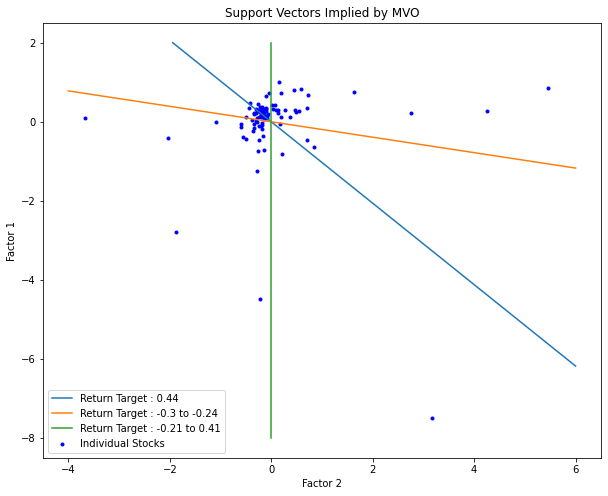

In [83]:
fig, ax = plt.subplots(figsize=(10,8))

# Plot volatility versus expected return for individual stocks
ax.scatter(x=Y_.iloc[:,0], y=Y_.iloc[:,1],
           color='Blue', label='Individual Stocks', marker = '.')
#for stock in Y_.index:
  #ax.annotate(stock, (Y_.loc[stock][0], Y_.loc[stock[1]))
for i in range(supports_uniq[[0,1,2]].values.shape[0]):
  print(i)
  line = getline(supports_uniq[[0,1,2]].values[i,:])
  if line is not None:
    ax.plot(*zip(*line), label = supports_uniq.iloc[i]['desc'])
plt.legend();
plt.ylabel('Factor 1')
plt.xlabel('Factor 2')
plt.title('Support Vectors Implied by MVO')